# Immorthon

## Installation des dépendances

In [6]:
!pip install transformers
!pip install datasets

## Import des modules et classes

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers.models.auto.tokenization_auto import AutoTokenizer
from transformers.models.auto.modeling_auto import AutoModelForCausalLM
from transformers.tokenization_utils_base import BatchEncoding
from transformers.training_args import TrainingArguments
from transformers.trainer import Trainer

## Préparation de l'environnement

In [9]:
# cloner si on est sur colab
if 'google.colab' in str(get_ipython()):
    repoDir = "immorthon/"
    !rm -rf immorthon
    !git clone https://github.com/sully-vian/immorthon.git
    !cd immorthon && unzip model.zip
else:
    repoDir = ""

dicoDir = "dictionnaries/"

# par ordre croissant de taille
dicoNames = ["dico-ef.csv", "dico-mit.csv", "dico-alpha.csv"]
dicoPath = dicoDir + dicoNames[2]

dicoPath = repoDir + dicoPath

# set pandas to print full strings
pd.set_option('display.max_colwidth', None)

Cloning into 'immorthon'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 110 (delta 44), reused 68 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 6.80 MiB | 20.13 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Archive:  model.zip
   creating: model/
  inflating: model/model.safetensors  
  inflating: model/generation_config.json  
  inflating: model/vocab.json        
  inflating: model/tokenizer_config.json  
  inflating: model/config.json       
  inflating: model/merges.txt        
  inflating: model/tokenizer.json    
  inflating: model/special_tokens_map.json  


## Chargement et préparation les données

In [10]:
# renvoie le dataFrame avec la colonne "text" ajoutée
def loadAndPreprocessData(dicoPath:str) -> pd.DataFrame:
    df = pd.read_csv(dicoPath, encoding="utf-8", on_bad_lines="error", na_filter=False)
    # On ne veut pas de valeur "None"
    if df.isnull().values.any():
        raise ValueError("None values in dataframe")
    # créer la colonne sur laquelle on va entrainer le modèle
    df["text"] = "Define: " + df["word"] + "\n" + df["definition"]
    return df

df = loadAndPreprocessData(dicoPath)

# séparer aléatoirement la data en train et test
dataset = Dataset.from_pandas(df[["text"]])
splitDataset = dataset.train_test_split(test_size=0.1)

## Représentation des données

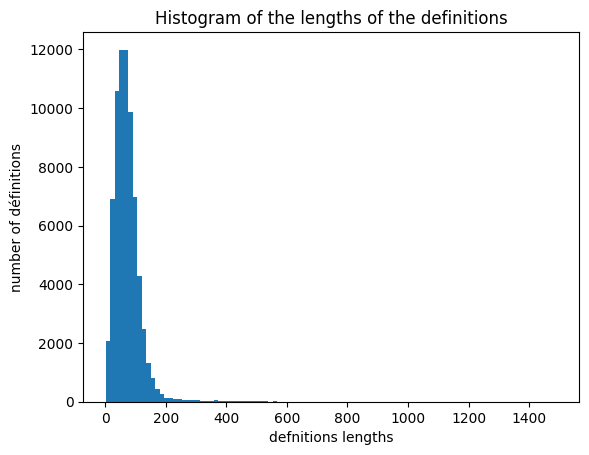

In [11]:
definition_lengths = [len(definition) for definition in df["definition"]]
plt.hist(definition_lengths, bins=100)
plt.title('Histogram of the lengths of the definitions')
plt.xlabel('defnitions lengths')
plt.ylabel('number of définitions')
plt.show()

## Import du modèle et du tokeniseur

In [12]:
# par ordre croissant de taille
modelNames = [
    repoDir + "model", # modèle entrainé sur des définitions
    "distilgpt2",
    "gpt2",
    "databricks/dolly-v2-3b" # trop lourd pour un T4 GPU
]
modelName = modelNames[0]

model = AutoModelForCausalLM.from_pretrained(modelName)
tokenizer = AutoTokenizer.from_pretrained(modelName)
tokenizer.pad_token = tokenizer.eos_token


## Tokenisation des données d'entrainement

In [13]:
def tokenizeDataSet(dataset: DatasetDict, tokenizer: AutoTokenizer, max_length) -> DatasetDict:
    def tokenize(examples: pd.DataFrame) -> BatchEncoding:
        encoding = tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )
        encoding["labels"] = encoding["input_ids"].copy()
        return encoding
    return dataset.map(tokenize, batched=True)

tokenizedDataset = tokenizeDataSet(splitDataset, tokenizer, 100)

Map:   0%|          | 0/63909 [00:00<?, ? examples/s]

Map:   0%|          | 0/7101 [00:00<?, ? examples/s]

## Entrainement

In [14]:
trainingArgs = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="no",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=tokenizedDataset["train"],
    eval_dataset=tokenizedDataset["test"],
    processing_class=tokenizer,
)

trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,2.688600
20,0.906500
30,0.773200
40,0.689500
50,0.682300
60,0.720400
70,0.662500
80,0.694700
90,0.731000
100,0.703300


TrainOutput(global_step=7989, training_loss=0.5537575768176987, metrics={'train_runtime': 1298.3457, 'train_samples_per_second': 49.223, 'train_steps_per_second': 6.153, 'total_flos': 1630782620467200.0, 'train_loss': 0.5537575768176987, 'epoch': 1.0})

## Affichage des données d'entrainement

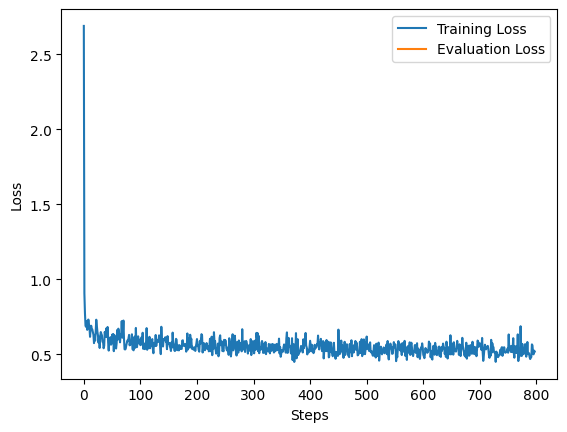

In [15]:
logHistory = trainer.state.log_history

trainLosses = [log["loss"] for log in logHistory if "loss" in log]
evalLosses = [log["eval_loss"] for log in logHistory if "eval_loss" in log] # vide, mais jsp pk

plt.plot(trainLosses, label="Training Loss")
plt.plot(evalLosses, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Utilisation du modèle

In [27]:
from transformers.pipelines import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate(prompt, numDef):
    fullPrompt = f"Define: {prompt}\n"
    results = generator(fullPrompt, max_length=64, num_return_sequences=numDef, do_sample=True, temperature=0.7, truncation=True)
    return [result["generated_text"] for result in results]

for result in generate("reich", 3):
    print(result, end="\n\n")

Device set to use cuda:0


Define: reich
a first name for girls

Define: reich
a person who has become a member of a group of people who now belong to a larger group of people who share the same opinion

Define: reich
a person or thing that is very well known or well known



## Enregistrement du modèle entrainé

In [28]:
# enregistrer le modèle
model.save_pretrained("model")
tokenizer.save_pretrained("model")
# zipper le modèle
!zip -r model.zip model

updating: model/ (stored 0%)
updating: model/model.safetensors (deflated 7%)
updating: model/generation_config.json (deflated 24%)
updating: model/vocab.json (deflated 59%)
updating: model/tokenizer_config.json (deflated 56%)
updating: model/config.json (deflated 51%)
updating: model/merges.txt (deflated 53%)
updating: model/tokenizer.json (deflated 82%)
updating: model/special_tokens_map.json (deflated 74%)
